<a href="https://colab.research.google.com/github/mkorlyakova/SiamNet-Tracking/blob/master/Train_SiamNet_(_CIFAR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import and Function definition:

DeepLearning framework:
tensorflow 2.x
Keras 2.3


Image processing framework:
PIL
cv2

Utilit:

google.colab


Запуск из Колаборатории - это формирование обученной сети SiamNet типа 



In [ ]:
#Install

# Currently %tensorflow_version 2.x installs beta1, which doesn't work here.
from __future__ import absolute_import, division, print_function, unicode_literals
# Install TensorFlow
import tensorflow as tf
# 
import tensorflow as tf
# Keras modules.
from tensorflow.python.keras.layers import Dense,Input, Conv2D, Flatten, Dropout, MaxPooling2D,Conv1D,Subtract, BatchNormalization 
from tensorflow.python.keras.models import Model

from tensorflow.python.keras.layers import Lambda, Conv1D, Reshape
from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# function for Lambda layer
def abs_layer(x):
  return tf.abs(x)

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


In [ ]:
import pandas as pd

In [ ]:
#!pip install autokeras
#!pip install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc1

Mount Google Drive and Read directori path to Image for **detect**

Подключаю диск и записываю директорию для чтения файлов 

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#root_path = '/content/drive/My Drive/Moutain_Bike/mountain-bike/'  #change dir to your project folder  



Mounted at /content/drive


In [ ]:
!git clone -l -s -- https://github.com/mkorlyakova/SiamNet-Tracking.git

In [ ]:
root_path = '/content/SiamNet-Tracking/Image/'  

Read filename List (for detect).

Чтение имен кадров для трекинга в базе 

In [ ]:
import os, fnmatch
listOfFiles = os.listdir(root_path)
pattern = '*.jpg'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[0]


array('/content/drive/My Drive/Moutain_Bike/mountain-bike/datasets_36409_55264_TrackingDataset_Kwon_VTD_basketball_frame_0001.jpg',
      dtype='<U122')

Создание маленькой сети для классификации :
из этого классификатора построю Сиамскую сеть

Данные для обучения - Cifaf100 (нет цели получить распознавание, нужно настроить сделать свертки для работы с картинкой - можно взять претренированную сеть, но хотелось использовать, что-то оченm маленькое и легкое)

In [ ]:
from tensorflow.python.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
# читаю CIFAR100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
# нормализаация к [0,1]
x_train=x_train/255
x_test =x_test/255
# one-hot-encoding
y_train100=to_categorical(y_train,100)
y_test100=to_categorical(y_test,100)
y_train100.shape, x_train.shape

((50000, 100), (50000, 32, 32, 3))

Epoch 1/20
400/400 [==============================] - 4s 9ms/step - loss: 4.0918 - accuracy: 0.0761 - val_loss: 3.7868 - val_accuracy: 0.1156
Epoch 2/20
400/400 [==============================] - 3s 8ms/step - loss: 3.4827 - accuracy: 0.1727 - val_loss: 3.3472 - val_accuracy: 0.1979
Epoch 3/20
400/400 [==============================] - 3s 8ms/step - loss: 3.1421 - accuracy: 0.2357 - val_loss: 3.1260 - val_accuracy: 0.2392
Epoch 4/20
400/400 [==============================] - 3s 8ms/step - loss: 2.9063 - accuracy: 0.2805 - val_loss: 3.0012 - val_accuracy: 0.2646
Epoch 5/20
400/400 [==============================] - 3s 8ms/step - loss: 2.7309 - accuracy: 0.3133 - val_loss: 2.8939 - val_accuracy: 0.2823
Epoch 6/20
400/400 [==============================] - 3s 8ms/step - loss: 2.5871 - accuracy: 0.3428 - val_loss: 2.7984 - val_accuracy: 0.3123
Epoch 7/20
400/400 [==============================] - 3s 8ms/step - loss: 2.4644 - accuracy: 0.3688 - val_loss: 2.7187 - val_accuracy: 0.3246
Epoch 

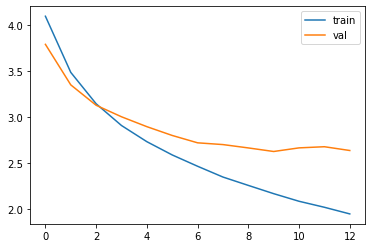

In [ ]:
def model_classif(level=2, n_dense = 100):
  x_inp =Input(shape=(32,32,3))
  # собираю сетку
  x=BatchNormalization()(x_inp)
  x=Conv2D(32, (5, 5) , activation='relu', padding='same')(x)
  x=Conv2D(32, (3, 3) , activation='relu', padding='same')(x)
  x=MaxPooling2D()(x)
  # будет не менее одного стека сверток+пулинг
  for k in range(level):
    x=Conv2D(32, (3, 3) , activation='relu', padding='same')(x)
    x=Conv2D(32, (3, 3) , activation='relu', padding='same')(x)
    x=MaxPooling2D()(x)
  x=Flatten()(x)
  # можно сделать второй слой полносвязки, но это сильно утяжелит сеть
  if n_dense>0:
    x_1=Dense(n_dense, activation = 'relu')(x)
  else:
    x_1=x
  x_2=Dense(100,activation='softmax')(x_1)
  classifier =Model(x_inp,x_2)
  siam_classifier =Model(x_inp,x_1)
  classifier.compile(optimizer='Adam', loss=['categorical_crossentropy'],metrics=['accuracy'])
  return  classifier ,siam_classifier

classifier ,siam_classifier = model_classif(level=2, n_dense = 100)

el=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=3,verbose=0, mode='auto', baseline=None,restore_best_weights=False)
hist=classifier.fit(x_train,y_train100,batch_size=100,epochs=20,validation_split=0.2,callbacks=[el])
plt.plot(hist.history['loss'],label='train')
plt.plot(hist.history['val_loss'],label='val')
plt.legend()
plt.show()


In [ ]:
el=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=3,verbose=0, mode='auto', baseline=None,restore_best_weights=True)

def gridSearch_net(vberbose_train=1,calback_net=[], net_param=[2,100,100,20] ):
  classifier ,siam_classifier = model_classif(level=net_param[0], n_dense = net_param[1])

  hist=classifier.fit(x_train,y_train100,batch_size=net_param[2],epochs=net_param[3],validation_split=0.2,callbacks=calback_net, verbose=vberbose_train)
  if vberbose_train==1:
    plt.plot(hist.history['loss'],label='train')
    plt.plot(hist.history['val_loss'],label='val')
    plt.title('net: Level:'+str(net_param[0])+'  , dense: '+str(net_param[1]))
    plt.legend()
    plt.show()
  return hist.history['loss'][-1] , hist.history['val_loss'][-1] ,classifier ,siam_classifier



Подбор параметров модели

Epoch 1/20
1250/1250 [==============================] - 7s 5ms/step - loss: 3.5661 - accuracy: 0.1772 - val_loss: 3.1180 - val_accuracy: 0.2528
Epoch 2/20
1250/1250 [==============================] - 7s 5ms/step - loss: 2.7775 - accuracy: 0.3241 - val_loss: 2.8444 - val_accuracy: 0.3154
Epoch 3/20
1250/1250 [==============================] - 7s 5ms/step - loss: 2.2997 - accuracy: 0.4182 - val_loss: 2.7246 - val_accuracy: 0.3455
Epoch 4/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9337 - accuracy: 0.4973 - val_loss: 2.7759 - val_accuracy: 0.3532
Epoch 5/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.6275 - accuracy: 0.5664 - val_loss: 2.9527 - val_accuracy: 0.3466
Epoch 6/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3799 - accuracy: 0.6209 - val_loss: 3.2002 - val_accuracy: 0.3337


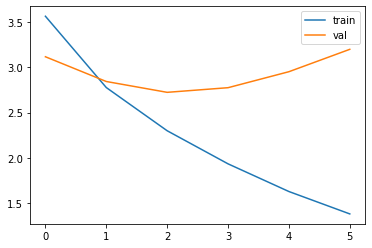

Epoch 1/20
625/625 [==============================] - 4s 7ms/step - loss: 3.6269 - accuracy: 0.1654 - val_loss: 3.1455 - val_accuracy: 0.2558
Epoch 2/20
625/625 [==============================] - 4s 7ms/step - loss: 2.7972 - accuracy: 0.3202 - val_loss: 2.8177 - val_accuracy: 0.3215
Epoch 3/20
625/625 [==============================] - 4s 6ms/step - loss: 2.3194 - accuracy: 0.4164 - val_loss: 2.6766 - val_accuracy: 0.3533
Epoch 4/20
625/625 [==============================] - 4s 6ms/step - loss: 1.9601 - accuracy: 0.4933 - val_loss: 2.7289 - val_accuracy: 0.3519
Epoch 5/20
625/625 [==============================] - 4s 6ms/step - loss: 1.6696 - accuracy: 0.5565 - val_loss: 2.8204 - val_accuracy: 0.3551
Epoch 6/20
625/625 [==============================] - 4s 6ms/step - loss: 1.4151 - accuracy: 0.6158 - val_loss: 2.9225 - val_accuracy: 0.3566


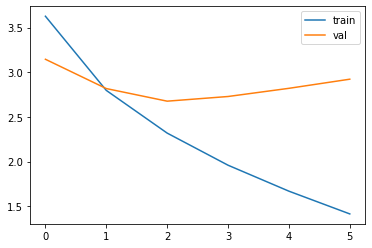

Epoch 1/20
313/313 [==============================] - 3s 10ms/step - loss: 3.6746 - accuracy: 0.1569 - val_loss: 3.2614 - val_accuracy: 0.2306
Epoch 2/20
313/313 [==============================] - 3s 9ms/step - loss: 2.9100 - accuracy: 0.2952 - val_loss: 2.9270 - val_accuracy: 0.2926
Epoch 3/20
313/313 [==============================] - 3s 9ms/step - loss: 2.5207 - accuracy: 0.3725 - val_loss: 2.7759 - val_accuracy: 0.3253
Epoch 4/20
313/313 [==============================] - 3s 9ms/step - loss: 2.2046 - accuracy: 0.4405 - val_loss: 2.7160 - val_accuracy: 0.3458
Epoch 5/20
313/313 [==============================] - 3s 9ms/step - loss: 1.9360 - accuracy: 0.5000 - val_loss: 2.7772 - val_accuracy: 0.3470
Epoch 6/20
313/313 [==============================] - 3s 9ms/step - loss: 1.7070 - accuracy: 0.5496 - val_loss: 2.8783 - val_accuracy: 0.3499
Epoch 7/20
313/313 [==============================] - 3s 9ms/step - loss: 1.4854 - accuracy: 0.6000 - val_loss: 2.9687 - val_accuracy: 0.3564


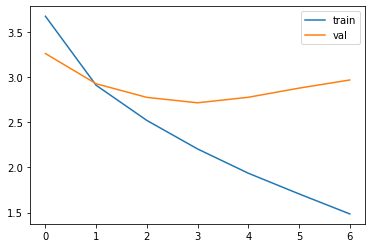

Epoch 1/20
1250/1250 [==============================] - 8s 6ms/step - loss: 3.8398 - accuracy: 0.1178 - val_loss: 3.4277 - val_accuracy: 0.1919
Epoch 2/20
1250/1250 [==============================] - 7s 6ms/step - loss: 3.1863 - accuracy: 0.2334 - val_loss: 3.0872 - val_accuracy: 0.2546
Epoch 3/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.8352 - accuracy: 0.3015 - val_loss: 2.9056 - val_accuracy: 0.2901
Epoch 4/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.6032 - accuracy: 0.3466 - val_loss: 2.8445 - val_accuracy: 0.3059
Epoch 5/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.4206 - accuracy: 0.3830 - val_loss: 2.7347 - val_accuracy: 0.3230
Epoch 6/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.2786 - accuracy: 0.4125 - val_loss: 2.7479 - val_accuracy: 0.3268
Epoch 7/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.1591 - accuracy: 0.4396 - val_loss: 2.7214 - val_accuracy:

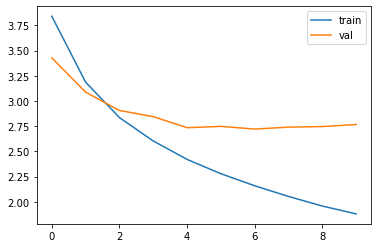

Epoch 1/20
625/625 [==============================] - 4s 7ms/step - loss: 3.8562 - accuracy: 0.1177 - val_loss: 3.5055 - val_accuracy: 0.1745
Epoch 2/20
625/625 [==============================] - 4s 7ms/step - loss: 3.1894 - accuracy: 0.2325 - val_loss: 3.0701 - val_accuracy: 0.2526
Epoch 3/20
625/625 [==============================] - 4s 6ms/step - loss: 2.8652 - accuracy: 0.2948 - val_loss: 2.9508 - val_accuracy: 0.2760
Epoch 4/20
625/625 [==============================] - 4s 7ms/step - loss: 2.6293 - accuracy: 0.3414 - val_loss: 2.8181 - val_accuracy: 0.3045
Epoch 5/20
625/625 [==============================] - 4s 7ms/step - loss: 2.4401 - accuracy: 0.3807 - val_loss: 2.6890 - val_accuracy: 0.3323
Epoch 6/20
625/625 [==============================] - 4s 7ms/step - loss: 2.2849 - accuracy: 0.4133 - val_loss: 2.6700 - val_accuracy: 0.3462
Epoch 7/20
625/625 [==============================] - 4s 7ms/step - loss: 2.1555 - accuracy: 0.4423 - val_loss: 2.7085 - val_accuracy: 0.3396
Epoch 

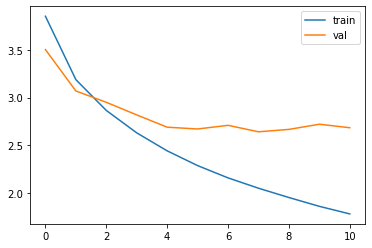

Epoch 1/20
313/313 [==============================] - 3s 10ms/step - loss: 3.9463 - accuracy: 0.1028 - val_loss: 3.6143 - val_accuracy: 0.1628
Epoch 2/20
313/313 [==============================] - 3s 9ms/step - loss: 3.3321 - accuracy: 0.2087 - val_loss: 3.2806 - val_accuracy: 0.2161
Epoch 3/20
313/313 [==============================] - 3s 9ms/step - loss: 3.0043 - accuracy: 0.2682 - val_loss: 3.0175 - val_accuracy: 0.2711
Epoch 4/20
313/313 [==============================] - 3s 9ms/step - loss: 2.7699 - accuracy: 0.3146 - val_loss: 2.9236 - val_accuracy: 0.2954
Epoch 5/20
313/313 [==============================] - 3s 9ms/step - loss: 2.5852 - accuracy: 0.3534 - val_loss: 2.8144 - val_accuracy: 0.3096
Epoch 6/20
313/313 [==============================] - 3s 9ms/step - loss: 2.4428 - accuracy: 0.3804 - val_loss: 2.7916 - val_accuracy: 0.3129
Epoch 7/20
313/313 [==============================] - 3s 9ms/step - loss: 2.3038 - accuracy: 0.4101 - val_loss: 2.6728 - val_accuracy: 0.3480
Epoch

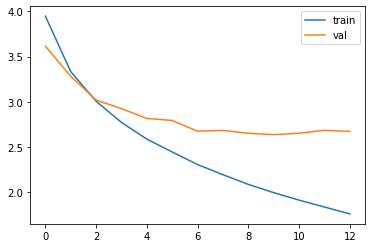

Epoch 1/20
1250/1250 [==============================] - 8s 7ms/step - loss: 4.1079 - accuracy: 0.0682 - val_loss: 3.8240 - val_accuracy: 0.1170
Epoch 2/20
1250/1250 [==============================] - 8s 6ms/step - loss: 3.6012 - accuracy: 0.1502 - val_loss: 3.4519 - val_accuracy: 0.1693
Epoch 3/20
1250/1250 [==============================] - 8s 6ms/step - loss: 3.2851 - accuracy: 0.2065 - val_loss: 3.2317 - val_accuracy: 0.2146
Epoch 4/20
1250/1250 [==============================] - 8s 7ms/step - loss: 3.0746 - accuracy: 0.2465 - val_loss: 3.1110 - val_accuracy: 0.2363
Epoch 5/20
1250/1250 [==============================] - 8s 6ms/step - loss: 2.9252 - accuracy: 0.2714 - val_loss: 3.0320 - val_accuracy: 0.2534
Epoch 6/20
1250/1250 [==============================] - 8s 7ms/step - loss: 2.8069 - accuracy: 0.2950 - val_loss: 2.9814 - val_accuracy: 0.2680
Epoch 7/20
1250/1250 [==============================] - 8s 6ms/step - loss: 2.7030 - accuracy: 0.3173 - val_loss: 2.9421 - val_accuracy:

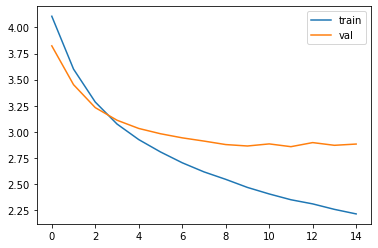

Epoch 1/20
625/625 [==============================] - 5s 8ms/step - loss: 4.1081 - accuracy: 0.0692 - val_loss: 3.7787 - val_accuracy: 0.1103
Epoch 2/20
625/625 [==============================] - 5s 7ms/step - loss: 3.5927 - accuracy: 0.1494 - val_loss: 3.4491 - val_accuracy: 0.1762
Epoch 3/20
625/625 [==============================] - 5s 7ms/step - loss: 3.2928 - accuracy: 0.2055 - val_loss: 3.2504 - val_accuracy: 0.2096
Epoch 4/20
625/625 [==============================] - 5s 7ms/step - loss: 3.0777 - accuracy: 0.2454 - val_loss: 3.1284 - val_accuracy: 0.2377
Epoch 5/20
625/625 [==============================] - 5s 7ms/step - loss: 2.9054 - accuracy: 0.2786 - val_loss: 2.9521 - val_accuracy: 0.2697
Epoch 6/20
625/625 [==============================] - 5s 8ms/step - loss: 2.7639 - accuracy: 0.3041 - val_loss: 2.9366 - val_accuracy: 0.2745
Epoch 7/20
625/625 [==============================] - 5s 8ms/step - loss: 2.6502 - accuracy: 0.3255 - val_loss: 2.9038 - val_accuracy: 0.2793
Epoch 

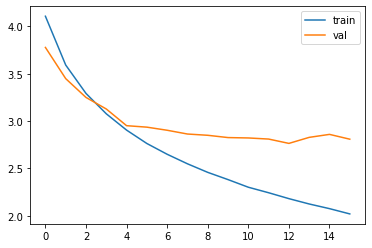

Epoch 1/20
313/313 [==============================] - 3s 11ms/step - loss: 4.1454 - accuracy: 0.0676 - val_loss: 3.8121 - val_accuracy: 0.1180
Epoch 2/20
313/313 [==============================] - 3s 10ms/step - loss: 3.6552 - accuracy: 0.1411 - val_loss: 3.5522 - val_accuracy: 0.1590
Epoch 3/20
313/313 [==============================] - 3s 10ms/step - loss: 3.3853 - accuracy: 0.1859 - val_loss: 3.2952 - val_accuracy: 0.2061
Epoch 4/20
313/313 [==============================] - 3s 10ms/step - loss: 3.1581 - accuracy: 0.2288 - val_loss: 3.1406 - val_accuracy: 0.2327
Epoch 5/20
313/313 [==============================] - 3s 10ms/step - loss: 2.9712 - accuracy: 0.2623 - val_loss: 3.1052 - val_accuracy: 0.2419
Epoch 6/20
313/313 [==============================] - 3s 10ms/step - loss: 2.8380 - accuracy: 0.2891 - val_loss: 3.0100 - val_accuracy: 0.2636
Epoch 7/20
313/313 [==============================] - 3s 10ms/step - loss: 2.7195 - accuracy: 0.3127 - val_loss: 2.9079 - val_accuracy: 0.2739

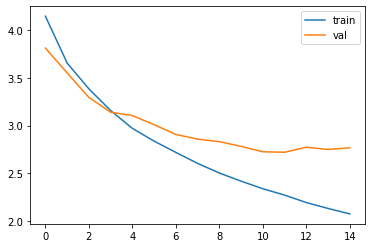

Epoch 1/20
1250/1250 [==============================] - 7s 5ms/step - loss: 3.8608 - accuracy: 0.1147 - val_loss: 3.4486 - val_accuracy: 0.1751
Epoch 2/20
1250/1250 [==============================] - 7s 5ms/step - loss: 3.1277 - accuracy: 0.2395 - val_loss: 3.0022 - val_accuracy: 0.2692
Epoch 3/20
1250/1250 [==============================] - 6s 5ms/step - loss: 2.7300 - accuracy: 0.3154 - val_loss: 2.7905 - val_accuracy: 0.3088
Epoch 4/20
1250/1250 [==============================] - 7s 5ms/step - loss: 2.4673 - accuracy: 0.3663 - val_loss: 2.7436 - val_accuracy: 0.3301
Epoch 5/20
1250/1250 [==============================] - 7s 5ms/step - loss: 2.2698 - accuracy: 0.4103 - val_loss: 2.6793 - val_accuracy: 0.3360
Epoch 6/20
1250/1250 [==============================] - 7s 5ms/step - loss: 2.1064 - accuracy: 0.4392 - val_loss: 2.6905 - val_accuracy: 0.3371
Epoch 7/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.9701 - accuracy: 0.4700 - val_loss: 2.7226 - val_accuracy:

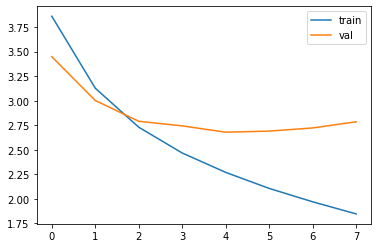

Epoch 1/20
625/625 [==============================] - 4s 6ms/step - loss: 3.9495 - accuracy: 0.1033 - val_loss: 3.5309 - val_accuracy: 0.1681
Epoch 2/20
625/625 [==============================] - 4s 6ms/step - loss: 3.2564 - accuracy: 0.2195 - val_loss: 3.1200 - val_accuracy: 0.2437
Epoch 3/20
625/625 [==============================] - 4s 6ms/step - loss: 2.8737 - accuracy: 0.2877 - val_loss: 2.9352 - val_accuracy: 0.2859
Epoch 4/20
625/625 [==============================] - 4s 6ms/step - loss: 2.6058 - accuracy: 0.3410 - val_loss: 2.8293 - val_accuracy: 0.3025
Epoch 5/20
625/625 [==============================] - 4s 6ms/step - loss: 2.4029 - accuracy: 0.3822 - val_loss: 2.6980 - val_accuracy: 0.3277
Epoch 6/20
625/625 [==============================] - 4s 6ms/step - loss: 2.2421 - accuracy: 0.4186 - val_loss: 2.7104 - val_accuracy: 0.3338
Epoch 7/20
625/625 [==============================] - 4s 6ms/step - loss: 2.1033 - accuracy: 0.4451 - val_loss: 2.6847 - val_accuracy: 0.3382
Epoch 

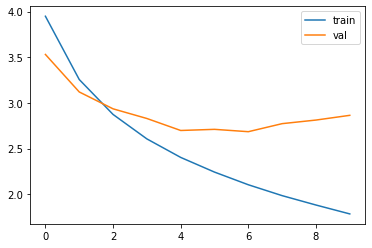

Epoch 1/20
313/313 [==============================] - 3s 10ms/step - loss: 3.9813 - accuracy: 0.1007 - val_loss: 3.5989 - val_accuracy: 0.1664
Epoch 2/20
313/313 [==============================] - 3s 9ms/step - loss: 3.2781 - accuracy: 0.2179 - val_loss: 3.1433 - val_accuracy: 0.2438
Epoch 3/20
313/313 [==============================] - 3s 9ms/step - loss: 2.8802 - accuracy: 0.2905 - val_loss: 2.9756 - val_accuracy: 0.2817
Epoch 4/20
313/313 [==============================] - 3s 9ms/step - loss: 2.6011 - accuracy: 0.3467 - val_loss: 2.7621 - val_accuracy: 0.3183
Epoch 5/20
313/313 [==============================] - 3s 9ms/step - loss: 2.3798 - accuracy: 0.3888 - val_loss: 2.7181 - val_accuracy: 0.3283
Epoch 6/20
313/313 [==============================] - 3s 9ms/step - loss: 2.2102 - accuracy: 0.4250 - val_loss: 2.6442 - val_accuracy: 0.3487
Epoch 7/20
313/313 [==============================] - 3s 9ms/step - loss: 2.0579 - accuracy: 0.4602 - val_loss: 2.6458 - val_accuracy: 0.3499
Epoch

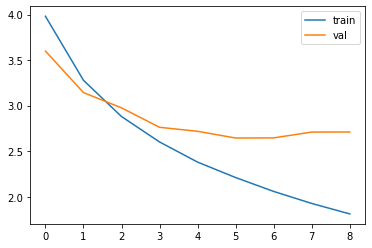

Epoch 1/20
1250/1250 [==============================] - 8s 6ms/step - loss: 4.0587 - accuracy: 0.0796 - val_loss: 3.7015 - val_accuracy: 0.1334
Epoch 2/20
1250/1250 [==============================] - 7s 6ms/step - loss: 3.4226 - accuracy: 0.1817 - val_loss: 3.2431 - val_accuracy: 0.2150
Epoch 3/20
1250/1250 [==============================] - 8s 6ms/step - loss: 3.0762 - accuracy: 0.2457 - val_loss: 3.0464 - val_accuracy: 0.2503
Epoch 4/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.8610 - accuracy: 0.2858 - val_loss: 2.9280 - val_accuracy: 0.2700
Epoch 5/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.7192 - accuracy: 0.3126 - val_loss: 2.9364 - val_accuracy: 0.2814
Epoch 6/20
1250/1250 [==============================] - 8s 6ms/step - loss: 2.5910 - accuracy: 0.3424 - val_loss: 2.8219 - val_accuracy: 0.3045
Epoch 7/20
1250/1250 [==============================] - 8s 7ms/step - loss: 2.4840 - accuracy: 0.3611 - val_loss: 2.7981 - val_accuracy:

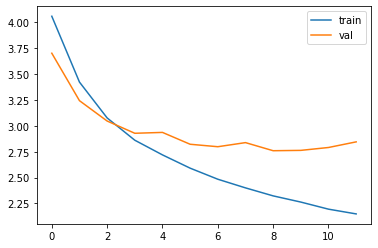

Epoch 1/20
625/625 [==============================] - 4s 7ms/step - loss: 4.0691 - accuracy: 0.0821 - val_loss: 3.7243 - val_accuracy: 0.1407
Epoch 2/20
625/625 [==============================] - 4s 7ms/step - loss: 3.4992 - accuracy: 0.1714 - val_loss: 3.4006 - val_accuracy: 0.1868
Epoch 3/20
625/625 [==============================] - 4s 7ms/step - loss: 3.1825 - accuracy: 0.2245 - val_loss: 3.1598 - val_accuracy: 0.2368
Epoch 4/20
625/625 [==============================] - 4s 7ms/step - loss: 2.9480 - accuracy: 0.2697 - val_loss: 3.0009 - val_accuracy: 0.2618
Epoch 5/20
625/625 [==============================] - 4s 7ms/step - loss: 2.7649 - accuracy: 0.3049 - val_loss: 2.9437 - val_accuracy: 0.2849
Epoch 6/20
625/625 [==============================] - 4s 7ms/step - loss: 2.6239 - accuracy: 0.3309 - val_loss: 2.8191 - val_accuracy: 0.3019
Epoch 7/20
625/625 [==============================] - 4s 7ms/step - loss: 2.5053 - accuracy: 0.3572 - val_loss: 2.7825 - val_accuracy: 0.3100
Epoch 

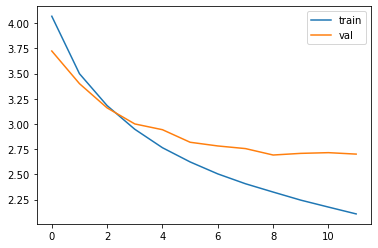

Epoch 1/20
313/313 [==============================] - 3s 10ms/step - loss: 4.2147 - accuracy: 0.0611 - val_loss: 3.8489 - val_accuracy: 0.1144
Epoch 2/20
313/313 [==============================] - 3s 9ms/step - loss: 3.6103 - accuracy: 0.1548 - val_loss: 3.5068 - val_accuracy: 0.1729
Epoch 3/20
313/313 [==============================] - 3s 9ms/step - loss: 3.2534 - accuracy: 0.2136 - val_loss: 3.1841 - val_accuracy: 0.2312
Epoch 4/20
313/313 [==============================] - 3s 10ms/step - loss: 3.0117 - accuracy: 0.2582 - val_loss: 3.0633 - val_accuracy: 0.2517
Epoch 5/20
313/313 [==============================] - 3s 10ms/step - loss: 2.8297 - accuracy: 0.2932 - val_loss: 2.9663 - val_accuracy: 0.2765
Epoch 6/20
313/313 [==============================] - 3s 9ms/step - loss: 2.6862 - accuracy: 0.3211 - val_loss: 2.8744 - val_accuracy: 0.2956
Epoch 7/20
313/313 [==============================] - 3s 10ms/step - loss: 2.5613 - accuracy: 0.3464 - val_loss: 2.8223 - val_accuracy: 0.3027
Ep

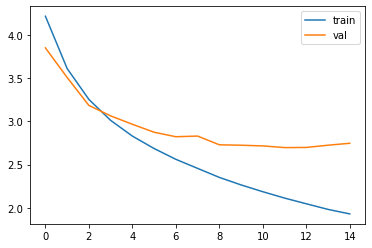

Epoch 1/20
1250/1250 [==============================] - 8s 7ms/step - loss: 4.2201 - accuracy: 0.0455 - val_loss: 3.9058 - val_accuracy: 0.0866
Epoch 2/20
1250/1250 [==============================] - 8s 7ms/step - loss: 3.7381 - accuracy: 0.1196 - val_loss: 3.5683 - val_accuracy: 0.1576
Epoch 3/20
1250/1250 [==============================] - 8s 6ms/step - loss: 3.4277 - accuracy: 0.1746 - val_loss: 3.3442 - val_accuracy: 0.1954
Epoch 4/20
1250/1250 [==============================] - 8s 7ms/step - loss: 3.2321 - accuracy: 0.2109 - val_loss: 3.2407 - val_accuracy: 0.2092
Epoch 5/20
1250/1250 [==============================] - 8s 7ms/step - loss: 3.0830 - accuracy: 0.2389 - val_loss: 3.1381 - val_accuracy: 0.2300
Epoch 6/20
1250/1250 [==============================] - 8s 6ms/step - loss: 2.9677 - accuracy: 0.2597 - val_loss: 3.0688 - val_accuracy: 0.2473
Epoch 7/20
1250/1250 [==============================] - 8s 7ms/step - loss: 2.8765 - accuracy: 0.2770 - val_loss: 3.0436 - val_accuracy:

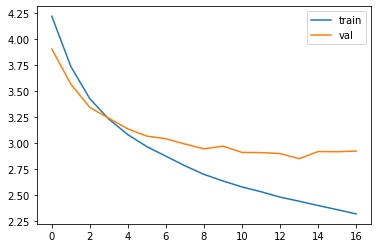

Epoch 1/20
625/625 [==============================] - 5s 8ms/step - loss: 4.2224 - accuracy: 0.0567 - val_loss: 3.8989 - val_accuracy: 0.1036
Epoch 2/20
625/625 [==============================] - 5s 7ms/step - loss: 3.7165 - accuracy: 0.1265 - val_loss: 3.5562 - val_accuracy: 0.1549
Epoch 3/20
625/625 [==============================] - 5s 7ms/step - loss: 3.4214 - accuracy: 0.1763 - val_loss: 3.3797 - val_accuracy: 0.1926
Epoch 4/20
625/625 [==============================] - 5s 8ms/step - loss: 3.2229 - accuracy: 0.2114 - val_loss: 3.2808 - val_accuracy: 0.2046
Epoch 5/20
625/625 [==============================] - 5s 7ms/step - loss: 3.0593 - accuracy: 0.2414 - val_loss: 3.1381 - val_accuracy: 0.2266
Epoch 6/20
625/625 [==============================] - 5s 8ms/step - loss: 2.9312 - accuracy: 0.2674 - val_loss: 3.0825 - val_accuracy: 0.2472
Epoch 7/20
625/625 [==============================] - 5s 8ms/step - loss: 2.8251 - accuracy: 0.2871 - val_loss: 2.9964 - val_accuracy: 0.2577
Epoch 

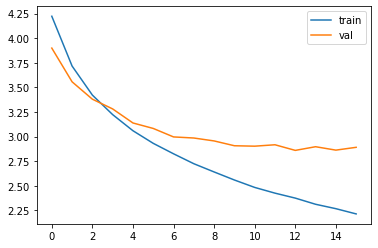

Epoch 1/20
313/313 [==============================] - 4s 11ms/step - loss: 4.2471 - accuracy: 0.0529 - val_loss: 3.9913 - val_accuracy: 0.0950
Epoch 2/20
313/313 [==============================] - 3s 10ms/step - loss: 3.7708 - accuracy: 0.1181 - val_loss: 3.6677 - val_accuracy: 0.1395
Epoch 3/20
313/313 [==============================] - 3s 10ms/step - loss: 3.5084 - accuracy: 0.1608 - val_loss: 3.5186 - val_accuracy: 0.1684
Epoch 4/20
313/313 [==============================] - 3s 10ms/step - loss: 3.3220 - accuracy: 0.1953 - val_loss: 3.3359 - val_accuracy: 0.1967
Epoch 5/20
313/313 [==============================] - 3s 10ms/step - loss: 3.1574 - accuracy: 0.2261 - val_loss: 3.1978 - val_accuracy: 0.2243
Epoch 6/20
313/313 [==============================] - 3s 10ms/step - loss: 3.0246 - accuracy: 0.2516 - val_loss: 3.1375 - val_accuracy: 0.2365
Epoch 7/20
313/313 [==============================] - 3s 10ms/step - loss: 2.9118 - accuracy: 0.2718 - val_loss: 3.0741 - val_accuracy: 0.2489

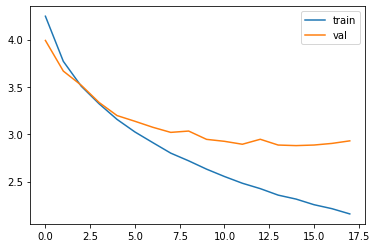

Epoch 1/20
1250/1250 [==============================] - 7s 5ms/step - loss: 3.6386 - accuracy: 0.1573 - val_loss: 3.1428 - val_accuracy: 0.2439
Epoch 2/20
1250/1250 [==============================] - 7s 5ms/step - loss: 2.8262 - accuracy: 0.3015 - val_loss: 2.8408 - val_accuracy: 0.3022
Epoch 3/20
1250/1250 [==============================] - 7s 5ms/step - loss: 2.3684 - accuracy: 0.3914 - val_loss: 2.7570 - val_accuracy: 0.3249
Epoch 4/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9967 - accuracy: 0.4718 - val_loss: 2.8189 - val_accuracy: 0.3386
Epoch 5/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6541 - accuracy: 0.5484 - val_loss: 2.9309 - val_accuracy: 0.3486
Epoch 6/20
1250/1250 [==============================] - 7s 6ms/step - loss: 1.3318 - accuracy: 0.6313 - val_loss: 3.1179 - val_accuracy: 0.3388


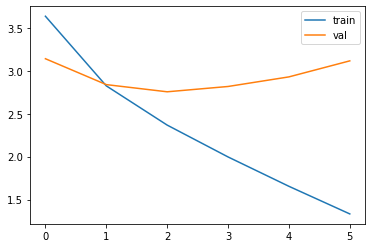

Epoch 1/20
625/625 [==============================] - 4s 7ms/step - loss: 3.7340 - accuracy: 0.1398 - val_loss: 3.2535 - val_accuracy: 0.2209
Epoch 2/20
625/625 [==============================] - 4s 6ms/step - loss: 2.9327 - accuracy: 0.2824 - val_loss: 2.9077 - val_accuracy: 0.2852
Epoch 3/20
625/625 [==============================] - 4s 6ms/step - loss: 2.4722 - accuracy: 0.3734 - val_loss: 2.6779 - val_accuracy: 0.3323
Epoch 4/20
625/625 [==============================] - 4s 6ms/step - loss: 2.0935 - accuracy: 0.4554 - val_loss: 2.6852 - val_accuracy: 0.3431
Epoch 5/20
625/625 [==============================] - 4s 6ms/step - loss: 1.7382 - accuracy: 0.5360 - val_loss: 2.8283 - val_accuracy: 0.3334
Epoch 6/20
625/625 [==============================] - 4s 6ms/step - loss: 1.4326 - accuracy: 0.6048 - val_loss: 3.0122 - val_accuracy: 0.3315


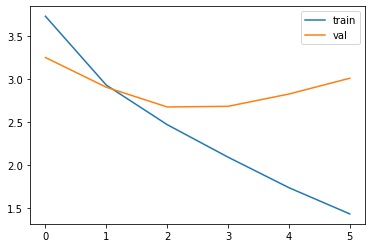

Epoch 1/20
313/313 [==============================] - 3s 10ms/step - loss: 3.7866 - accuracy: 0.1323 - val_loss: 3.3502 - val_accuracy: 0.2151
Epoch 2/20
313/313 [==============================] - 3s 9ms/step - loss: 3.0146 - accuracy: 0.2696 - val_loss: 2.9383 - val_accuracy: 0.2884
Epoch 3/20
313/313 [==============================] - 3s 9ms/step - loss: 2.5705 - accuracy: 0.3527 - val_loss: 2.7194 - val_accuracy: 0.3286
Epoch 4/20
313/313 [==============================] - 3s 9ms/step - loss: 2.2420 - accuracy: 0.4246 - val_loss: 2.6709 - val_accuracy: 0.3499
Epoch 5/20
313/313 [==============================] - 3s 9ms/step - loss: 1.9599 - accuracy: 0.4857 - val_loss: 2.6405 - val_accuracy: 0.3590
Epoch 6/20
313/313 [==============================] - 3s 9ms/step - loss: 1.6994 - accuracy: 0.5416 - val_loss: 2.7519 - val_accuracy: 0.3487
Epoch 7/20
313/313 [==============================] - 3s 9ms/step - loss: 1.4498 - accuracy: 0.6038 - val_loss: 2.9382 - val_accuracy: 0.3492
Epoch

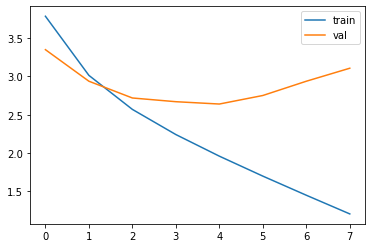

Epoch 1/20
1250/1250 [==============================] - 8s 6ms/step - loss: 3.8518 - accuracy: 0.1133 - val_loss: 3.4179 - val_accuracy: 0.1872
Epoch 2/20
1250/1250 [==============================] - 7s 6ms/step - loss: 3.1860 - accuracy: 0.2256 - val_loss: 3.1042 - val_accuracy: 0.2427
Epoch 3/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.8463 - accuracy: 0.2891 - val_loss: 2.9281 - val_accuracy: 0.2777
Epoch 4/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.6031 - accuracy: 0.3382 - val_loss: 2.8183 - val_accuracy: 0.3069
Epoch 5/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.4090 - accuracy: 0.3804 - val_loss: 2.8050 - val_accuracy: 0.3141
Epoch 6/20
1250/1250 [==============================] - 8s 6ms/step - loss: 2.2354 - accuracy: 0.4171 - val_loss: 2.7748 - val_accuracy: 0.3232
Epoch 7/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.0814 - accuracy: 0.4480 - val_loss: 2.8065 - val_accuracy:

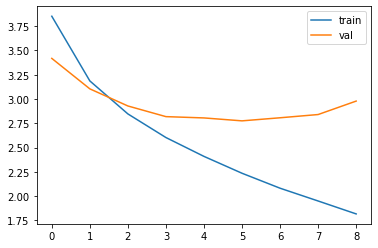

Epoch 1/20
625/625 [==============================] - 5s 8ms/step - loss: 3.9346 - accuracy: 0.1019 - val_loss: 3.5151 - val_accuracy: 0.1702
Epoch 2/20
625/625 [==============================] - 4s 7ms/step - loss: 3.2766 - accuracy: 0.2120 - val_loss: 3.1903 - val_accuracy: 0.2285
Epoch 3/20
625/625 [==============================] - 4s 7ms/step - loss: 2.9014 - accuracy: 0.2817 - val_loss: 2.9662 - val_accuracy: 0.2707
Epoch 4/20
625/625 [==============================] - 4s 7ms/step - loss: 2.6388 - accuracy: 0.3317 - val_loss: 2.8348 - val_accuracy: 0.3017
Epoch 5/20
625/625 [==============================] - 4s 7ms/step - loss: 2.4162 - accuracy: 0.3774 - val_loss: 2.7465 - val_accuracy: 0.3192
Epoch 6/20
625/625 [==============================] - 4s 7ms/step - loss: 2.2263 - accuracy: 0.4188 - val_loss: 2.8057 - val_accuracy: 0.3179
Epoch 7/20
625/625 [==============================] - 4s 7ms/step - loss: 2.0597 - accuracy: 0.4545 - val_loss: 2.8762 - val_accuracy: 0.3213
Epoch 

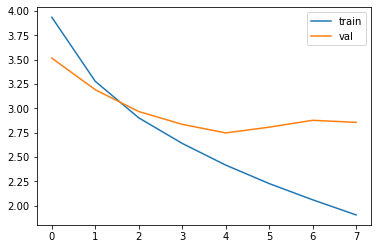

Epoch 1/20
313/313 [==============================] - 3s 10ms/step - loss: 3.9784 - accuracy: 0.0931 - val_loss: 3.6120 - val_accuracy: 0.1550
Epoch 2/20
313/313 [==============================] - 3s 10ms/step - loss: 3.3180 - accuracy: 0.2058 - val_loss: 3.1766 - val_accuracy: 0.2302
Epoch 3/20
313/313 [==============================] - 3s 10ms/step - loss: 2.9576 - accuracy: 0.2695 - val_loss: 3.0254 - val_accuracy: 0.2638
Epoch 4/20
313/313 [==============================] - 3s 10ms/step - loss: 2.6971 - accuracy: 0.3242 - val_loss: 2.8409 - val_accuracy: 0.2967
Epoch 5/20
313/313 [==============================] - 3s 10ms/step - loss: 2.4679 - accuracy: 0.3709 - val_loss: 2.7500 - val_accuracy: 0.3222
Epoch 6/20
313/313 [==============================] - 3s 9ms/step - loss: 2.2999 - accuracy: 0.4058 - val_loss: 2.7593 - val_accuracy: 0.3217
Epoch 7/20
313/313 [==============================] - 3s 10ms/step - loss: 2.1202 - accuracy: 0.4435 - val_loss: 2.7277 - val_accuracy: 0.3261


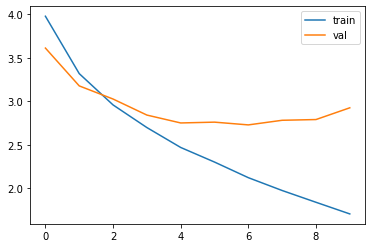

Epoch 1/20
1250/1250 [==============================] - 9s 7ms/step - loss: 4.1133 - accuracy: 0.0683 - val_loss: 3.7322 - val_accuracy: 0.1227
Epoch 2/20
1250/1250 [==============================] - 8s 6ms/step - loss: 3.5555 - accuracy: 0.1533 - val_loss: 3.4475 - val_accuracy: 0.1712
Epoch 3/20
1250/1250 [==============================] - 8s 6ms/step - loss: 3.2885 - accuracy: 0.2023 - val_loss: 3.2454 - val_accuracy: 0.2141
Epoch 4/20
1250/1250 [==============================] - 8s 6ms/step - loss: 3.0994 - accuracy: 0.2368 - val_loss: 3.1559 - val_accuracy: 0.2363
Epoch 5/20
1250/1250 [==============================] - 8s 6ms/step - loss: 2.9567 - accuracy: 0.2598 - val_loss: 3.0680 - val_accuracy: 0.2509
Epoch 6/20
1250/1250 [==============================] - 8s 6ms/step - loss: 2.8290 - accuracy: 0.2874 - val_loss: 3.0160 - val_accuracy: 0.2600
Epoch 7/20
1250/1250 [==============================] - 8s 6ms/step - loss: 2.7260 - accuracy: 0.3077 - val_loss: 2.9775 - val_accuracy:

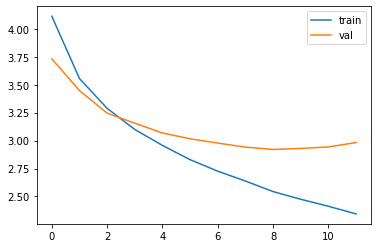

Epoch 1/20
625/625 [==============================] - 5s 8ms/step - loss: 4.0755 - accuracy: 0.0740 - val_loss: 3.7073 - val_accuracy: 0.1276
Epoch 2/20
625/625 [==============================] - 5s 7ms/step - loss: 3.5362 - accuracy: 0.1561 - val_loss: 3.4139 - val_accuracy: 0.1795
Epoch 3/20
625/625 [==============================] - 5s 8ms/step - loss: 3.2595 - accuracy: 0.2065 - val_loss: 3.2309 - val_accuracy: 0.2142
Epoch 4/20
625/625 [==============================] - 5s 7ms/step - loss: 3.0559 - accuracy: 0.2427 - val_loss: 3.1079 - val_accuracy: 0.2366
Epoch 5/20
625/625 [==============================] - 5s 7ms/step - loss: 2.9000 - accuracy: 0.2736 - val_loss: 3.0576 - val_accuracy: 0.2496
Epoch 6/20
625/625 [==============================] - 5s 8ms/step - loss: 2.7657 - accuracy: 0.2997 - val_loss: 2.9418 - val_accuracy: 0.2770
Epoch 7/20
625/625 [==============================] - 5s 7ms/step - loss: 2.6407 - accuracy: 0.3221 - val_loss: 2.8740 - val_accuracy: 0.2860
Epoch 

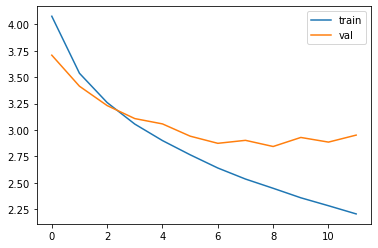

Epoch 1/20
313/313 [==============================] - 3s 11ms/step - loss: 4.1491 - accuracy: 0.0609 - val_loss: 3.8552 - val_accuracy: 0.1056
Epoch 2/20
313/313 [==============================] - 3s 10ms/step - loss: 3.6215 - accuracy: 0.1425 - val_loss: 3.5171 - val_accuracy: 0.1589
Epoch 3/20
313/313 [==============================] - 3s 10ms/step - loss: 3.3112 - accuracy: 0.1981 - val_loss: 3.2810 - val_accuracy: 0.2066
Epoch 4/20
313/313 [==============================] - 3s 10ms/step - loss: 3.0933 - accuracy: 0.2385 - val_loss: 3.1337 - val_accuracy: 0.2328
Epoch 5/20
313/313 [==============================] - 3s 10ms/step - loss: 2.9208 - accuracy: 0.2716 - val_loss: 3.0491 - val_accuracy: 0.2509
Epoch 6/20
313/313 [==============================] - 3s 10ms/step - loss: 2.7739 - accuracy: 0.3000 - val_loss: 2.9441 - val_accuracy: 0.2675
Epoch 7/20
313/313 [==============================] - 3s 10ms/step - loss: 2.6546 - accuracy: 0.3261 - val_loss: 2.8965 - val_accuracy: 0.2832

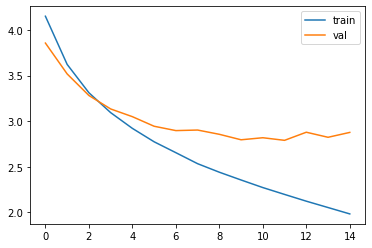

In [ ]:
Resume = pd.DataFrame(data=np.array([[0,0,0,0]]), columns = ['Level','Dense','train','test'])
k=0


for n_dense in [0,64,256]:
  for level_net in [1,2,3]:
    e_test = []
    e_train = []
    for batch_s in [32,64,128]:
      e_tr, e_te,_,_ =gridSearch_net(vberbose_train=1,calback_net=[el], net_param=[level_net,n_dense,batch_s,20] )
      e_test.append(e_tr)
      e_train.append(e_te)

    Resume.loc[k,:]=np.array([level_net, n_dense,np.mean(e_train),np.mean(e_test)])
    k += 1



Результаты поиска:

In [ ]:
Resume

,Level,Dense,train,test
0,1.0,0.0,3.030462,1.426811
1,2.0,0.0,2.706762,1.804502
2,3.0,0.0,2.820120,2.102870
3,1.0,64.0,2.786534,1.813842
4,2.0,64.0,2.764423,2.062578
5,3.0,64.0,2.915765,2.231773
6,1.0,256.0,3.079365,1.323423
7,2.0,256.0,2.919281,1.808065
8,3.0,256.0,2.936988,2.177928


Лучший набор параметров

In [ ]:
Resume.loc[Resume['test']==np.min(Resume['test'].values),:]

,Level,Dense,train,test
6,1.0,256.0,3.079365,1.323423


Epoch 1/20
200/200 [==============================] - 2s 12ms/step - loss: 3.8355 - accuracy: 0.1285 - val_loss: 3.5774 - val_accuracy: 0.1922
Epoch 2/20
200/200 [==============================] - 2s 11ms/step - loss: 3.1128 - accuracy: 0.2511 - val_loss: 3.0187 - val_accuracy: 0.2698
Epoch 3/20
200/200 [==============================] - 2s 11ms/step - loss: 2.6840 - accuracy: 0.3325 - val_loss: 2.8626 - val_accuracy: 0.3041
Epoch 4/20
200/200 [==============================] - 2s 11ms/step - loss: 2.3592 - accuracy: 0.3984 - val_loss: 2.7517 - val_accuracy: 0.3312
Epoch 5/20
200/200 [==============================] - 2s 11ms/step - loss: 2.0768 - accuracy: 0.4604 - val_loss: 2.7677 - val_accuracy: 0.3337
Epoch 6/20
200/200 [==============================] - 2s 11ms/step - loss: 1.8373 - accuracy: 0.5119 - val_loss: 2.7922 - val_accuracy: 0.3377
Epoch 7/20
200/200 [==============================] - 2s 11ms/step - loss: 1.5851 - accuracy: 0.5710 - val_loss: 2.9723 - val_accuracy: 0.3362

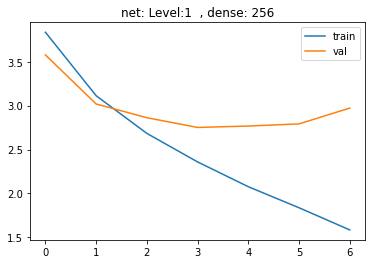

In [ ]:
e_tr, e_te, classif_best,siam_classifier_best =gridSearch_net(vberbose_train=1,calback_net=[el], net_param=[1,256,200,20] )

In [ ]:
classif_best.save_weights('classif.h5')

In [ ]:
classifier1.summary()

Model: "functional_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_230 (Conv2D)          (None, 32, 32, 32)        2432      
_________________________________________________________________
conv2d_231 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_232 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 16, 16, 32)     

# **Формируем нейронную сеть - сиамского типа**

Create SiamNet:



In [ ]:
classifier1 ,siam_classifier1 = model_classif(level=1, n_dense = 256)
classifier2 ,siam_classifier2 = model_classif(level=1, n_dense = 256)

classifier2.load_weights('classif.hdf5')
classifier1.load_weights('classif.hdf5')

classifier2.trainable=False
classifier1.trainable=False


flat1 = (classifier1.layers[-2].output)
flat2 = (classifier2.layers[-2].output)

flat_1=Subtract()([flat1,flat2])
flat_ = Lambda(abs_layer)(flat_1)
class1 = Dense(256, activation='relu')(flat_)
output = Dense(1, activation='sigmoid')(class1)

model_ = Model([classifier2.input,classifier1.input], output)

model_.compile(optimizer='SGD',loss=['binary_crossentropy'],metrics=['accuracy'])

el=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5,verbose=0, mode='auto', baseline=None,restore_best_weights=False)
model_.summary()


Model: "functional_185"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_45 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 32, 32, 3)    12          input_44[0][0]                   
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 32, 32, 3)    12          input_45[0][0]                   
_____________________________________________________________________________________

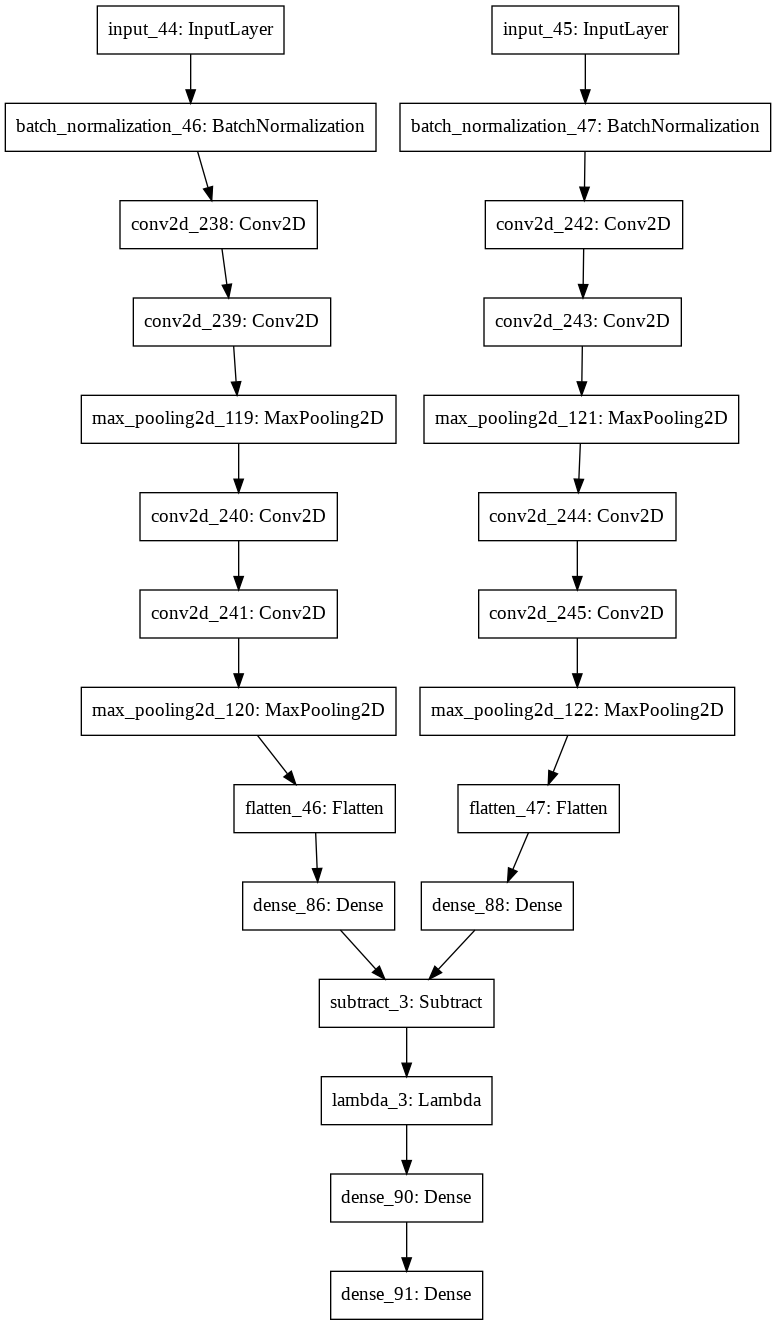

In [ ]:
plot_model(model_, to_file='model_.png')

Dataset for SiamNet Train:

1th Imagei - cifar100, 2th Imagei + augmentation(cifar100) -> Label = 1

1th Imagei - cifar100, 2th Imagej - cifar100 -> Label = 0


1th Image - X1

2th Image - X2

Label - L

Создаем генератор для аугментации:
- поворот до 30 гр.
- масштаб до 0.2 (20%)
- сдвиги 0.2 (20%)
- горизонтальное отражение

In [ ]:
IDG = ImageDataGenerator(rotation_range=30,zoom_range=0.2,height_shift_range=0.2,width_shift_range=0.2,horizontal_flip=True ,rescale=1, brightness_range=[0.7, 0.9])

IDG.fit(x_train)


Строю выборку для тренировки.

In [ ]:

N=20000
X1=[]
X2=[]

L=[]
for i in range(N):
  wi=np.random.randint(0,x_train.shape[0])
  wj=np.random.randint(0,x_train.shape[0])
  X1.append(x_train[wi])
  if wi == wj:
    I1=IDG.apply_transform(x_train[wi,:,:,:],IDG.get_random_transform((32,32,3)))/255
    X2.append(x_train[wj])
    L.append(1)
    #X2.append(x_train[wj])
  else :
    X1.append(x_train[wi])
    X2.append(x_train[wj])  
    L.append(0)  

  I1=IDG.apply_transform(x_train[wi,:,:,:],IDG.get_random_transform((32,32,3)))/255
  X2.append(I1)
  L.append(1)
 

    
X1=np.array(X1)
X2=np.array(X2)
L=np.array(L).astype('int')

Запустили обучение модели и отобразим кривые обучения и валидации

Epoch 1/30
160/160 [==============================] - 2s 10ms/step - loss: 0.5919 - accuracy: 0.6432 - val_loss: 0.5067 - val_accuracy: 0.7569
Epoch 2/30
160/160 [==============================] - 1s 8ms/step - loss: 0.4662 - accuracy: 0.7853 - val_loss: 0.4412 - val_accuracy: 0.8075
Epoch 3/30
160/160 [==============================] - 1s 8ms/step - loss: 0.4155 - accuracy: 0.8273 - val_loss: 0.4025 - val_accuracy: 0.8455
Epoch 4/30
160/160 [==============================] - 1s 8ms/step - loss: 0.3820 - accuracy: 0.8491 - val_loss: 0.3735 - val_accuracy: 0.8584
Epoch 5/30
160/160 [==============================] - 1s 8ms/step - loss: 0.3570 - accuracy: 0.8618 - val_loss: 0.3521 - val_accuracy: 0.8675
Epoch 6/30
160/160 [==============================] - 1s 7ms/step - loss: 0.3349 - accuracy: 0.8741 - val_loss: 0.3345 - val_accuracy: 0.8711
Epoch 7/30
160/160 [==============================] - 1s 7ms/step - loss: 0.3168 - accuracy: 0.8839 - val_loss: 0.3143 - val_accuracy: 0.8826
Epoch

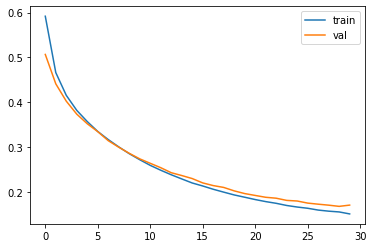

In [ ]:
hist1=model_.fit([X1,X2],L,batch_size=200,epochs=30,validation_split=0.2, callbacks=[el])
plt.plot(hist1.history['loss'],label='train')
plt.plot(hist1.history['val_loss'],label='val')
plt.legend()
plt.show()

Обучение не сошлось, добаляю еще немного эпох

Epoch 1/10
160/160 [==============================] - 1s 8ms/step - loss: 0.1327 - accuracy: 0.9520 - val_loss: 0.1519 - val_accuracy: 0.9417
Epoch 2/10
160/160 [==============================] - 1s 8ms/step - loss: 0.1314 - accuracy: 0.9529 - val_loss: 0.1506 - val_accuracy: 0.9414
Epoch 3/10
160/160 [==============================] - 1s 7ms/step - loss: 0.1307 - accuracy: 0.9518 - val_loss: 0.1497 - val_accuracy: 0.9411
Epoch 4/10
160/160 [==============================] - 1s 7ms/step - loss: 0.1287 - accuracy: 0.9530 - val_loss: 0.1504 - val_accuracy: 0.9420
Epoch 5/10
160/160 [==============================] - 1s 7ms/step - loss: 0.1286 - accuracy: 0.9530 - val_loss: 0.1482 - val_accuracy: 0.9414
Epoch 6/10
160/160 [==============================] - 1s 8ms/step - loss: 0.1275 - accuracy: 0.9522 - val_loss: 0.1502 - val_accuracy: 0.9410
Epoch 7/10
160/160 [==============================] - 1s 8ms/step - loss: 0.1252 - accuracy: 0.9539 - val_loss: 0.1467 - val_accuracy: 0.9416
Epoch 

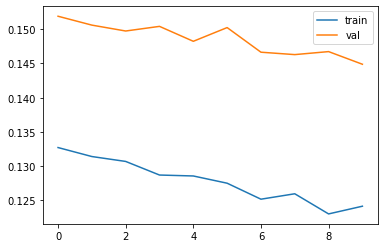

In [ ]:
hist1=model_.fit([X1,X2],L,batch_size=200,epochs=10,validation_split=0.2, callbacks=[el])
plt.plot(hist1.history['loss'],label='train')
plt.plot(hist1.history['val_loss'],label='val')
plt.legend()
plt.show()

Сохраняю веса модели

In [ ]:
model_.save_weights('/content/SiamNet-Tracking/siam_net_weight.h5')

Контроль

In [ ]:
y=model_.predict([X1[-10:,:,:,:],X2[-10:,:,:,:]])

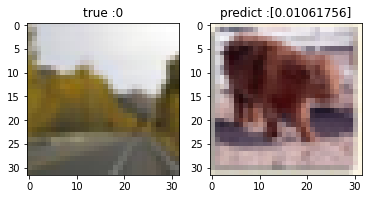

In [ ]:
n=-2

plt.subplot(1,2,1)
plt.imshow(X1[n,:,:,:])
plt.title('true :'+ str(L[n]))
plt.subplot(1,2,2)
plt.title('predict :'+str(y[n]))
plt.imshow(X2[n,:,:,:])
plt.show()

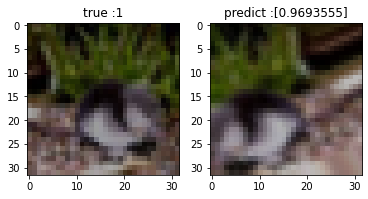

In [ ]:
n=-7

plt.subplot(1,2,1)
plt.imshow(X1[n,:,:,:])
plt.title('true :'+ str(L[n]))
plt.subplot(1,2,2)
plt.title('predict :'+str(y[n]))
plt.imshow(X2[n,:,:,:])
plt.show()

Соберу функцию для формирования сиамской сети и ее загрузки весами

In [ ]:

def model_classif_fin(level=2, n_dense = 100):
  # функция для обработки данных в плече сиамской сети
  x_inp =Input(shape=(32,32,3))
  # собираю сетку
  x=BatchNormalization()(x_inp)
  x=Conv2D(32, (5, 5) , activation='relu', padding='same')(x)
  x=Conv2D(32, (3, 3) , activation='relu', padding='same')(x)
  x=MaxPooling2D()(x)
  # будет не менее одного стека сверток+пулинг
  for k in range(level):
    x=Conv2D(32, (3, 3) , activation='relu', padding='same')(x)
    x=Conv2D(32, (3, 3) , activation='relu', padding='same')(x)
    x=MaxPooling2D()(x)
  x=Flatten()(x)
  # можно сделать второй слой полносвязки, но это сильно утяжелит сеть
  if n_dense>0:
    x_1=Dense(n_dense, activation = 'relu')(x)
  else:
    x_1=x

  siam_classifier =Model(x_inp,x_1)
  siam_classifier.compile(optimizer='Adam', loss=['categorical_crossentropy'],metrics=['accuracy'])
  return  siam_classifier

def SiamNet_create(siam_weigth ='/content/SiamNet-Tracking/siam_net_weight.h5' ):
  # имя файла весов сети
  classifier1  = model_classif_fin(level=1, n_dense = 256)
  classifier2  = model_classif_fin(level=1, n_dense = 256)

  flat1 = (classifier1.layers[-1].output)
  flat2 = (classifier2.layers[-1].output)

  flat_1=Subtract()([flat1,flat2])
  flat_ = Lambda(abs_layer)(flat_1)
  class1 = Dense(256, activation='relu')(flat_)
  output = Dense(1, activation='sigmoid')(class1)

  model_ = Model([classifier2.input,classifier1.input], output)
  
  model_.compile(optimizer='SGD',loss=['binary_crossentropy'],metrics=['accuracy'])

  model_.load_weights(siam_weigth)
  #print(model_.layers[-1])
  return model_

Проверяю работу функции

In [ ]:
new_model = SiamNet_create(siam_weigth ='/content/SiamNet-Tracking/siam_net_weight.h5' )

In [ ]:
y=new_model.predict([X1[-10:,:,:,:],X2[-10:,:,:,:]])

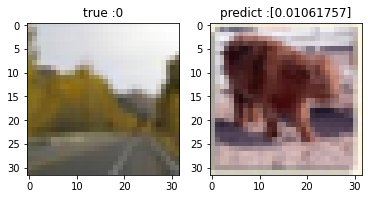

In [ ]:
n=-2

plt.subplot(1,2,1)
plt.imshow(X1[n,:,:,:])
plt.title('true :'+ str(L[n]))
plt.subplot(1,2,2)
plt.title('predict :'+str(y[n]))
plt.imshow(X2[n,:,:,:])
plt.show()

Результат воспроизводится верно. Запись состоялась успешно